In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torchvision import datasets,transforms
from torch.utils.data import DataLoader

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5071, 0.4867, 0.4408), (0.2675, 0.2565, 0.2761))
])

train_data= datasets.CIFAR10(root='data',
                                  download=True,
                                  train=True,
                                  transform=transform
                                  )
test_data= datasets.CIFAR10(root='data',
                                  download=True,
                                  train=False,
                                  transform=transform
)

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


In [3]:
image,label=train_data[0]
image.shape,label

(torch.Size([3, 32, 32]), 6)

In [4]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(50000, 50000, 10000, 10000)

In [5]:
class_names=train_data.classes
class_names


['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## Visualizing some images 😊😊

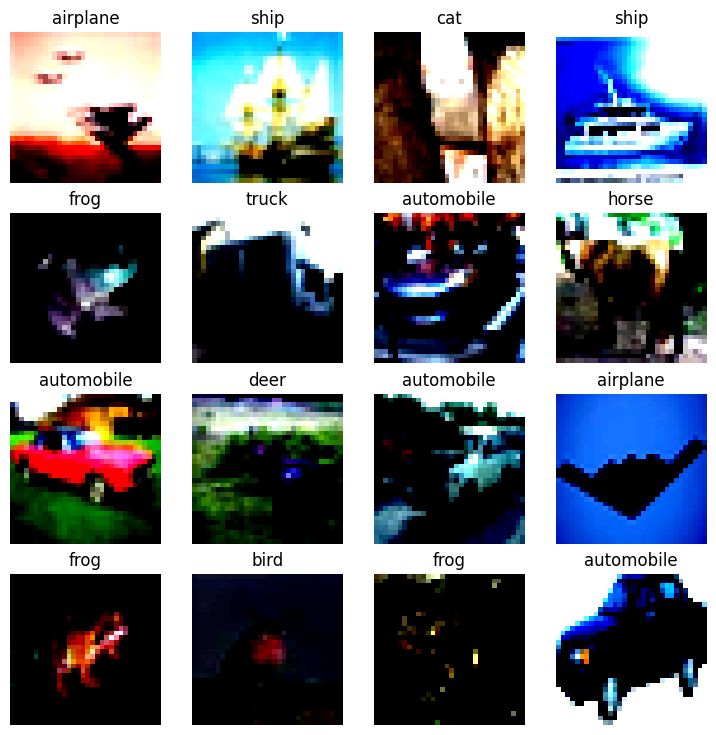

In [6]:
rows,columns=4,4
fig=plt.figure(figsize=(9,9))
for i in range(1,rows*columns+1):
  random_idx=torch.randint(0,len(train_data),size=[1]).item()
  image,label=train_data[random_idx]
  fig.add_subplot(rows,columns,i)
  plt.imshow(image.permute(1,2,0))
  plt.title(class_names[label])
  plt.axis(False)

plt.show()



In [7]:
# Setup the batch size hyperparameter
BATCH_SIZE = 32

# Turn datasets into iterables (batches)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE,shuffle=True)

test_dataloader = DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)

# Let's check out what we've created
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"Length of train dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7dffde611d10>, <torch.utils.data.dataloader.DataLoader object at 0x7dffd4f6c710>)
Length of train dataloader: 1563 batches of 32
Length of test dataloader: 313 batches of 32


In [8]:
# Check out what's inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 32, 32]), torch.Size([32]))

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, input_channels: int, hidden_units: int, output_classes: int):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(input_channels, hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2)  # [B, hidden_units, 16, 16]
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.Conv2d(hidden_units * 2, hidden_units * 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 2),
            nn.ReLU(),
            nn.MaxPool2d(2)  # [B, hidden_units*2, 8, 8]
        )


        self.block_3 = nn.Sequential(
            nn.Conv2d(hidden_units * 2, hidden_units * 4, kernel_size=3, padding=1),
            nn.BatchNorm2d(hidden_units * 4),
            nn.ReLU(),
            nn.MaxPool2d(2)  # [B, hidden_units*4, 4, 4]
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 4 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, output_classes)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.classifier(x)
        return x


In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CustomCNN(input_channels=3, hidden_units=64, output_classes=len(class_names)).to(device)
next(model.parameters()).device

device(type='cuda', index=0)

In [11]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

##training and testing functions

In [12]:
def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    total_loss, total_acc = 0, 0

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)

        # Forward
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()

        # Accuracy
        preds = torch.argmax(y_pred, 1)
        total_acc += (preds == y).sum().item()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / (len(dataloader.dataset))
    return avg_loss, avg_acc


def test_step(model, dataloader, loss_fn, device):
    model.eval()
    total_loss, total_acc = 0, 0

    with torch.inference_mode():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()

            preds = torch.argmax(y_pred, 1)
            total_acc += (preds == y).sum().item()

    avg_loss = total_loss / len(dataloader)
    avg_acc = total_acc / (len(dataloader.dataset))
    return avg_loss, avg_acc


## Evaluation function

In [13]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               device: torch.device = device):

    model.eval()
    total_loss = 0
    total_correct = 0

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            # Loss
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()

            # Accuracy
            preds = y_pred.argmax(dim=1)
            total_correct += (preds == y).sum().item()

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / len(data_loader.dataset)

    return {
        "model_name": model.__class__.__name__,
        "model_loss": avg_loss,
        "model_acc": avg_acc
    }




In [14]:
epochs = 7

from tqdm import tqdm

for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model, train_dataloader, loss_fn, optimizer, device)
    test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)


    print(f"Epoch {epoch+1}:")
    print(f"  Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%")
    print(f"  Test Loss:  {test_loss:.4f}, Test Acc:  {test_acc*100:.2f}%")



 14%|█▍        | 1/7 [00:26<02:38, 26.46s/it]

Epoch 1:
  Train Loss: 1.5262, Train Acc: 43.14%
  Test Loss:  1.0500, Test Acc:  62.42%


 29%|██▊       | 2/7 [00:50<02:06, 25.30s/it]

Epoch 2:
  Train Loss: 1.1205, Train Acc: 59.89%
  Test Loss:  0.9759, Test Acc:  66.13%


 43%|████▎     | 3/7 [01:14<01:37, 24.37s/it]

Epoch 3:
  Train Loss: 0.9321, Train Acc: 67.41%
  Test Loss:  0.7952, Test Acc:  72.61%


 57%|█████▋    | 4/7 [01:38<01:12, 24.16s/it]

Epoch 4:
  Train Loss: 0.8074, Train Acc: 72.15%
  Test Loss:  0.6615, Test Acc:  77.08%


 71%|███████▏  | 5/7 [02:01<00:47, 23.73s/it]

Epoch 5:
  Train Loss: 0.7053, Train Acc: 76.00%
  Test Loss:  0.6143, Test Acc:  79.30%


 86%|████████▌ | 6/7 [02:23<00:23, 23.22s/it]

Epoch 6:
  Train Loss: 0.6163, Train Acc: 79.12%
  Test Loss:  0.5422, Test Acc:  81.88%


100%|██████████| 7/7 [02:46<00:00, 23.75s/it]

Epoch 7:
  Train Loss: 0.5382, Train Acc: 81.86%
  Test Loss:  0.5192, Test Acc:  83.05%


In [14]:
model_results = eval_model(model=model,data_loader=test_dataloader,loss_fn=loss_fn,device=device)
model_results


##Visualizing how well can the model predicts correctly

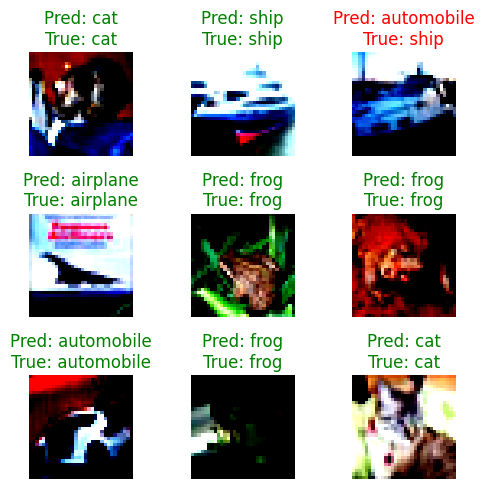

In [15]:
def plot_predictions(model, dataloader, class_names, device, n=9):
    model.eval()
    X_batch, y_batch = next(iter(dataloader))
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)

    with torch.inference_mode():
        y_pred = model(X_batch)
        pred_classes = torch.argmax(y_pred, 1)

    plt.figure(figsize=(5, 5))
    for i in range(n):
        plt.subplot(3, 3, i+1)
        plt.imshow(X_batch[i].permute(1, 2, 0).cpu())
        color = 'g' if pred_classes[i] == y_batch[i] else 'r'
        plt.title(f"Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[y_batch[i]]}", c=color)
        plt.axis("off")

    plt.tight_layout()
    plt.show()

plot_predictions(model, test_dataloader, class_names, device)

## Making a confusion matrix for further prediction evaluation

In [16]:
try:
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")
except:
    !pip install -q torchmetrics -U mlxtend # for installing mlxtend upgraded version
    import torchmetrics, mlxtend
    print(f"mlxtend version: {mlxtend.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.9/981.9 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 82.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 17.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 44.4 MB/s eta 0:00:00
mlxtend version: 0.23.4


In [17]:
# Get predictions
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in tqdm(test_dataloader, desc="Making predictions"):
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1)
    y_preds.append(y_pred.cpu())
# Concatenate list of predictions into a tensor
y_pred_tensor = torch.cat(y_preds)

Making predictions: 100%|██████████| 313/313 [00:04<00:00, 65.03it/s]


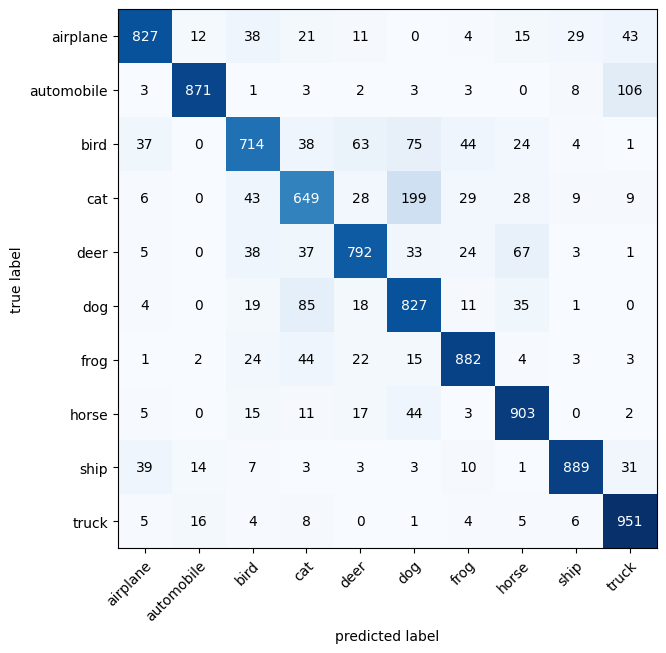

In [19]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

# Setup confusion matrix instance and compare predictions to targets
confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=torch.tensor(test_data.targets))

# Plot the confusion matrix
fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(), # matplotlib likes working with NumPy
    class_names=class_names, # turn the row and column labels into class names
    figsize=(10, 7)
);

#**Done 🚀🚀🔥🔥**